# Keras based GRU Network

## Prepare dataset

Reformat dataset to be int format
```
caption | valence_class
caption | {negative,neutral,positive}
```

In [1]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# fix random seed for reproducibility
seed = 7

captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
oasis_csv_path = "dataset/metadata/OASIS.csv"
captions_root_path = pathlib.Path(captions_root)

human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf.csv'
human_caption_csv_path = captions_root_path/'captions.csv'
neutralLow = 3.0 
neutralHigh = 5.0
dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)

auto_output_caption_to_label_csv_path = captions_root_path/'autoCaptionWithLabeldf.csv'
auto_caption_csv_path = captions_root_path/'auto_generated_captions.csv'
neutralLow = 3.0 
neutralHigh = 5.0
dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

None


## Set Keras to use Tensorflow GPU in the backend

In [2]:
import tensorflow as tf
from keras import backend as K

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 2
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading Fasttext Embeddings

You can download fasttext word vectors from here:

https://fasttext.cc/docs/en/english-vectors.html    
https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip
    

In [3]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GRU, Bidirectional, LSTM
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Masking
from keras.layers.core import  ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras.utils import multi_gpu_model
from keras import regularizers
from keras.regularizers import L1L2

from sklearn.metrics import f1_score
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import keras
from sklearn.model_selection import KFold
import os
import io
import numpy as np
import tensorflow as tf
from gensim.models import word2vec
import pandas as pd
# from fastText import load_model
from gensim.models.keyedvectors import KeyedVectors
from keras.preprocessing import text
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import StratifiedKFold

%matplotlib inline 

def load_embedding(path):
    word2vec = {}
    with io.open(path, encoding="utf8") as f:
        for line in f:
            entries = line.rstrip().split(" ")
            word, entries = entries[0], entries[1:]
            word2vec[word] = np.array(entries).astype(np.float) # Convert String type to float
    print('embedding size : %d' % len(word2vec))
    print('embedding dimension : %s' % (word2vec['apple'].shape,))
    return word2vec
    
wordToVec = {}


fasttext_embedding_path = 'embedding/wiki-news-300d-1M.vec'
wordToVec = load_embedding(fasttext_embedding_path)



embedding size : 999995
embedding dimension : (300,)


## Results

Epoch 300/300
663/663 [==============================] - 2s 3ms/step - loss: 0.1011 - acc: 0.9789 - val_loss: 1.9239 - val_acc: 0.6426

best_val_acc:  0.7148936180358237
filename adidas-0.7149-1527322080
Total time passed for training 9.198103360335033


In [4]:
import nltk
from nltk.corpus import stopwords
from keras.layers.core import  ActivityRegularization
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers.core import Flatten
from keras.layers import Activation, TimeDistributed, Embedding, GRU, Bidirectional, LSTM
from sklearn.metrics import f1_score
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

stop_words = set(stopwords.words('english'))

def plot_model_accuracy(history):
    """plot acc and loss for train and val"""
    filename = "hec" 
    filename = generate_model_name(filename + "-acc", max(history.history['val_acc']))
    fig = plt.figure()
    val_acc_list = history.history['val_acc']
    val_f1_list = history.history['val_f1']
    best_val_acc =  max(val_acc_list)
    best_f1 =  max(val_f1_list)
    print("best_val_acc", best_val_acc)
    print("best_train_acc", max(history.history['acc']))
    
    print("best_f1", best_f1)
    print("best_train_f1", max(history.history['f1']))
    
    #  "Accuracy"
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    fig.savefig("model/" + filename + ".png") 
    
    # "Loss"
    fig = plt.figure()
    filename = "hec" 
    filename = generate_model_name(filename + "-loss", min(history.history['val_loss']))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    fig.savefig("model/" + filename + ".png") 

def get_word_embedding(word):
    word = word.lower()
    if word in wordToVec:
        return wordToVec[word]
    else:
        return np.zeros(embedding_dimension,)
    
def get_sequence_embedding(words, max_seq_len):
    if len(words) <= max_seq_len:
        # Add padding
        x_seq = np.array([get_word_embedding(word) for word in words])
        x_seq = np.lib.pad(x_seq, ((0,max_seq_len-x_seq.shape[0]),(0,0)), 'constant')
    else:
        x_seq = []
        for i in range(max_seq_len):
            x_seq.append(get_word_embedding(words[i]))
        x_seq = np.array(x_seq)
    return x_seq
        
def convert_index_to_one_hot(y_train_index, num_of_classes):
    y_train = np.zeros((y_train_index.shape[0],num_of_classes))
    y_train[range(y_train_index.shape[0]),y_train_index] = 1
    return y_train


def generate_model_name(filename, best_acc_val):
    timestamp = str(time.time()).split(".")[0]
    best_acc_val = round(best_acc_val,4)
    filename += "-" + str(best_acc_val) + "-" + timestamp
    return filename

def get_words_withoutstopwords(words):
    words_without_stopwords = []
    for word in words:
        if word not in stop_words:
            words_without_stopwords.append(word)
    return words_without_stopwords

def load_dataset_StratifiedKFold(dfKFold, max_seq_len):
    sentences = []
    label_index = []
    num_of_classes = 0
    class_to_index = {}
    index_to_class = {}
    for index, row in dfKFold.iterrows():
        caption = row['caption']
        label = row['label']
        sentence = caption
        words = sentence.split(" ")
        words = get_non_stop_words(words)
        sentence_embedding = get_sequence_embedding(words, max_seq_len)
        sentences.append(sentence_embedding)
        if label in class_to_index:
            label_index.append(class_to_index[label])
        else:
            num_of_classes += 1
            class_to_index[label] = num_of_classes - 1
            index_to_class[num_of_classes - 1] = label
            label_index.append(class_to_index[label])
    X_train = np.array(sentences)
    y_train = np.array(label_index)
    return (X_train, y_train, num_of_classes)


def get_non_stop_word_count(words):
    count = 0
    for word in words:
        if word not in stop_words:
            count += 1
    return count


def get_non_stop_words(words):
    non_stop_words = []
    for word in words:
        if word not in stop_words:
            non_stop_words.append(word)
    return non_stop_words

def change_label_str_to_int(labelStr):
    if labelStr == "negative":
        return -1
    elif  labelStr == "neutral":
        return 0
    elif  labelStr == "positive":
        return 1

def change_label_str_to_int_binary(labelStr):
    """this is only for binary classification, negative sentiment has value 0, positive sentiment has value 1"""
    if labelStr == "negative":
        return 0
    elif  labelStr == "neutral":
        raise "Neutral Should not exist"
    elif  labelStr == "positive":
        return 1
    else:
        raise labelStr+ " Should not exist"

def get_df_for_binary_classification():
    df = pd.read_csv(dataset_path, header=0, sep="|")
    # Doing only binary classification
    df = df[(df.label == "negative") | (df.label == "positive")]
    df = df.reset_index()
    df["label"] = df["label"].apply(lambda x: change_label_str_to_int_binary(x))
    df["caption"] = df["caption"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
    return df

def precision(y_true, y_pred):
    """source: https://github.com/keras-team/keras/issues/5400"""
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """source: https://github.com/keras-team/keras/issues/5400"""
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    """source: https://github.com/keras-team/keras/issues/5400"""
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+ K.epsilon()))

def build_model(isBinaryClassification, max_seq_len, num_of_classes, embedding_dim, hidden_layer_dim, dropout, recurrent_dropout, final_activation): 
    # Cross-validation results: 0.61% (+/- 0.13%)
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, embedding_dim)))
    #, dropout=dropout, recurrent_dropout=recurrent_dropout
    model.add(Bidirectional(GRU(max_seq_len,return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(GRU(max_seq_len))) 
    model.add(Dropout(dropout))
    
    
    model.add(Dense(num_of_classes, activation=final_activation))

    if isBinaryClassification:
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1, recall, precision])
    else:
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=['accuracy', f1, recall, precision])
    print(model.summary())
    return model


def train_StratifiedKFold(isBinaryClassification):
    """StratifiedKFold cross-validation to solve class imbalance issue"""
    df = pd.read_csv(dataset_path, header=0, sep="|")
    df["label"] = df["label"].apply(lambda x: change_label_str_to_int(x))
    df["caption"] = df["caption"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
    print(df['caption'].head(5))
    print(df['label'].head(5))
    # Doing only binary classification
    if isBinaryClassification:
        df = get_df_for_binary_classification()
    
    X = df["caption"]
    y = df["label"]
    print("Label distribution: ",df.groupby('label').label.count())
    max_seq_len = int(df['caption'].map(lambda x: get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    
    # Instantiate the cross validator
    skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
    printCnt = 5
    cv_accuracies = []
    cv_f1s = []
    
    # Loop through the indices the split() method returns
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        start = time.time()
        print("\nTRAIN size:", len(train_indices), "\t VAL size:", len(val_indices))
        print("TRAIN[:5]:", train_indices[:printCnt], "\t VAL[:5]:", val_indices[:printCnt])
        print("TRAIN[-5:]:", train_indices[-printCnt:], "\t VAL[-5:]:", val_indices[-printCnt:])
        X_train, X_val = X[train_indices], X[val_indices]
        y_train_index, y_val_index = y[train_indices], y[val_indices]
        dfTrain = pd.concat([X_train, y_train_index], axis=1)
        dfTrain.columns = ['caption', 'label']
        X_train, y_train_index, num_of_classes = load_dataset_StratifiedKFold(dfTrain, max_seq_len)
        y_train = convert_index_to_one_hot(y_train_index, num_of_classes) 
        print(X_train[0])
        print(y_train[0])
        print("Train label distribution: ",dfTrain.groupby('label').label.count())
        dfVal= pd.concat([X_val, y_val_index], axis=1)
        dfVal.columns = ['caption', 'label']
        
        X_val, y_val_index, _ = load_dataset_StratifiedKFold(dfVal,max_seq_len)
        y_val = convert_index_to_one_hot(y_val_index, num_of_classes) 
        print("Val label distribution: ",dfVal.groupby('label').label.count())
        
        if isBinaryClassification:
            final_activation ='sigmoid'
        else:
            final_activation ='softmax'
        print("final_activation",final_activation)
        model = build_model(isBinaryClassification,
                            max_seq_len,
                            num_of_classes, 
                            embedding_dim=300, 
                            hidden_layer_dim=40, 
                            dropout=0.65, 
                            recurrent_dropout=0.65,# 0.3
                            final_activation=final_activation
                            )
        plot_model(model, to_file= 'model/model.png', show_shapes=True, show_layer_names=True)#
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.2, 
                                  patience=5, 
                                  min_lr=0.001)
        
        history = {}
        filename = ""
        # checkpoint
        filepath="model/weights.best.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', patience=20)
        
        callbacks_list = [ checkpoint, early_stopping, reduce_lr]  #
        history = model.fit(x=X_train,
                      y=y_train, 
                      batch_size=16,# 64 seems fine, 32 is better 
                      epochs=100, 
                      verbose=0, 
                      validation_data = (X_val, y_val),
                      shuffle=True,
                      callbacks=callbacks_list)        
        val_acc_list = history.history['val_acc']
        val_f1_list = history.history['val_f1']
        best_val_acc =  max(val_acc_list)
        best_f1 =  max(val_f1_list)
        print("best_val_acc: ", best_val_acc)
        print("best_f1: ", best_f1)
        filename = "hec" 
        filename = "model/" + generate_model_name(filename, best_val_acc) + ".h5"
        os.rename(filepath, filename)
        cv_accuracies.append(best_val_acc)
        cv_f1s.append(best_f1)
        plot_model_accuracy(history)
        end = time.time()
        print("Time passed for training", (end-start)/60)
    
    print("=========================================")
    print("Cross-validation val accuracy results: " , cv_accuracies)
    print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))
    
    print("\n","Cross-validation val f1 results: " , cv_f1s)
    print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))
    
    
    return history


dataset_path = human_output_caption_to_label_csv_path
kfold_splits = 7
# dataset_path = auto_output_caption_to_label_csv_path


embedding_dimension = 300
class_to_index = {}
index_to_class = {}
#max_seq_len = 40
start = time.time()
isBinaryClassification = True
#history = train_StratifiedKFold(isBinaryClassification) 
#dataset_path = caption_to_label_dataset_path + "/" +'human-train.csv'
#val_dataset_path = caption_to_label_dataset_path + "/" +'human-val.csv'
#history = train()
end = time.time()
print("Total time passed for training", (end-start)/60)


Total time passed for training 3.337860107421875e-07


## Determien Vocabulary size - unique word counts

In [5]:
df = pd.read_csv(dataset_path, header=0, sep="|")
df["caption"] = df["caption"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
vocabulary = set()
for index, row in df.iterrows():
    caption = row['caption']
    words = caption.lower().split()
    for word in words:
        vocabulary.add(word)
    
print("Voc size: ",len(vocabulary))    

Voc size:  2827


# New Train on Twitter dataset, validate on OASIS images caption dataset

1,578,628 Tweets with positive/negative sentiments - labelled data

In [6]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import warnings
warnings.filterwarnings('ignore')



b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


df.shape (1578612, 2)
df.head()                                              caption  label
0                                     sad apl friend      0
1                            missed new moon trailer      0
2                                   omg already 7 30      1
3  omgaga sooo gunna cry dentist since 11 suposed...      0
4                               think mi bf cheating      0


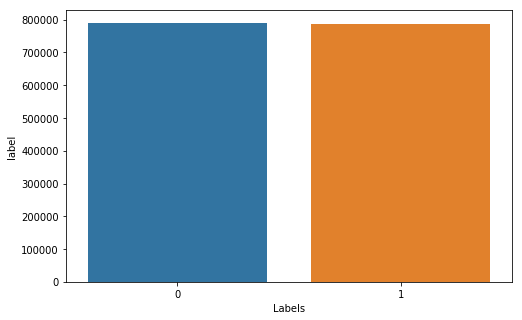

In [10]:
# nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
# def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

# def tweet_clean(text):
#     text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
#     text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
#     return text.strip()


# twitter_dataset_path = "/home/elkhand/datasets/twitter-sentiment/Sentiment_Analysis_Dataset.csv" 
# cleaned_twitter_dataset_path = "/home/elkhand/datasets/twitter-sentiment/Cleaned_Sentiment_Analysis_Dataset.csv" 
# df = pd.read_csv(twitter_dataset_path, error_bad_lines=False)
# df = df[['SentimentText','Sentiment']]
# df["SentimentText"] = df["SentimentText"].apply(lambda x: tokenizer(x))
# df["SentimentText"] = df["SentimentText"].apply(lambda x: " ".join(x))
# df["SentimentText"] = df["SentimentText"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
# df.columns = ['caption','label']
# df = df.dropna()
# df.to_csv(cleaned_twitter_dataset_path, index=False)
# print("df.shape", df.shape)
# print("df.head()", df.head())

# fig = plt.figure(figsize=(8,5))
# ax = sns.barplot(x=df.label.unique(),y=df.label.value_counts());
# ax.set(xlabel='Labels');

## Train on Twitter dataset, validate on Image captions

                                             caption  label
0                                     sad apl friend      0
1                            missed new moon trailer      0
2                                   omg already 7 30      1
3  omgaga sooo gunna cry dentist since 11 suposed...      0
4                               think mi bf cheating      0
dfTwitter.count() caption    1000
label      1000
dtype: int64
Label distribution:  label
0    163
1    317
Name: label, dtype: int64
max_seq_len_captions 27
max_seq_len_tweets 22
max_seq_len 27
final_activation sigmoid
Train label distribution:  label
0    639
1    771
Name: label, dtype: int64
num_of_classes 2
Val label distribution:  label
0    24
1    46
Name: label, dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_36 (Masking)         (None, None, 300)         0         
_______________________________________________________

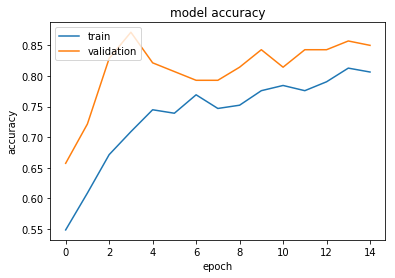

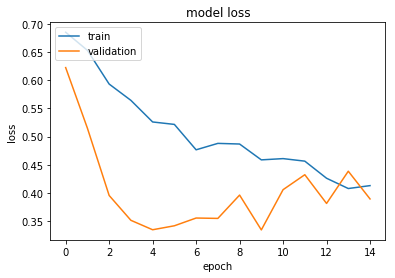

Time passed for training 1.084955358505249
Train label distribution:  label
0    639
1    771
Name: label, dtype: int64
num_of_classes 2
Val label distribution:  label
0    24
1    46
Name: label, dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_37 (Masking)         (None, None, 300)         0         
_________________________________________________________________
gru_97 (GRU)                 (None, None, 27)          26568     
_________________________________________________________________
gru_98 (GRU)                 (None, 27)                4455      
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 56        
Total params: 31,079
Trainable params: 31,079
Non-trainable params: 0
_________________________________________________________________
None
Train on 1410 samples, validate on 70 samples
Epoch 1/1

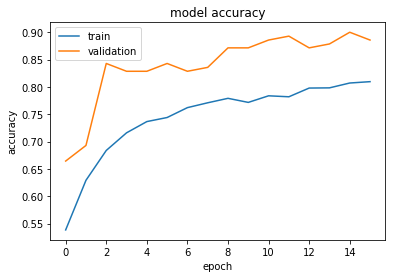

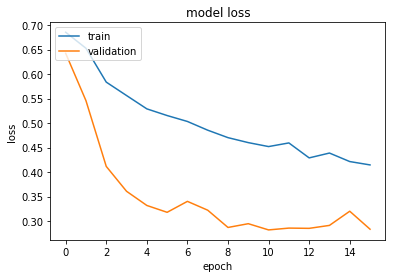

Time passed for training 2.2093211889266966
Train label distribution:  label
0    640
1    772
Name: label, dtype: int64
num_of_classes 2
Val label distribution:  label
0    23
1    45
Name: label, dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_38 (Masking)         (None, None, 300)         0         
_________________________________________________________________
gru_99 (GRU)                 (None, None, 27)          26568     
_________________________________________________________________
gru_100 (GRU)                (None, 27)                4455      
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 56        
Total params: 31,079
Trainable params: 31,079
Non-trainable params: 0
_________________________________________________________________
None
Train on 1412 samples, validate on 68 samples
Epoch 1/

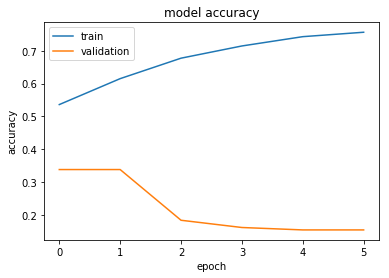

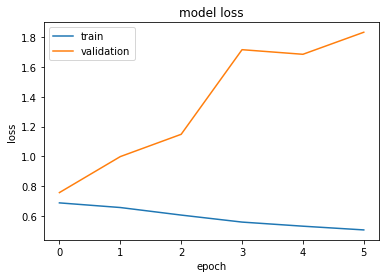

Time passed for training 2.7775681614875793
Train label distribution:  label
0    640
1    772
Name: label, dtype: int64
num_of_classes 2
Val label distribution:  label
0    23
1    45
Name: label, dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_39 (Masking)         (None, None, 300)         0         
_________________________________________________________________
gru_101 (GRU)                (None, None, 27)          26568     
_________________________________________________________________
gru_102 (GRU)                (None, 27)                4455      
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 56        
Total params: 31,079
Trainable params: 31,079
Non-trainable params: 0
_________________________________________________________________
None
Train on 1412 samples, validate on 68 samples
Epoch 1/

1412/1412 [==============================] - 3s 2ms/step - loss: 0.2911 - acc: 0.8708 - f1: 0.8707 - recall: 0.8711 - precision: 0.8705 - val_loss: 0.2092 - val_acc: 0.9118 - val_f1: 0.9118 - val_recall: 0.9118 - val_precision: 0.9118
Epoch 30/100
1412/1412 [==============================] - 3s 2ms/step - loss: 0.2843 - acc: 0.8807 - f1: 0.8806 - recall: 0.8796 - precision: 0.8816 - val_loss: 0.2190 - val_acc: 0.9412 - val_f1: 0.9412 - val_recall: 0.9412 - val_precision: 0.9412
Epoch 31/100
1412/1412 [==============================] - 3s 2ms/step - loss: 0.3073 - acc: 0.8669 - f1: 0.8669 - recall: 0.8669 - precision: 0.8669 - val_loss: 0.2141 - val_acc: 0.9118 - val_f1: 0.9118 - val_recall: 0.9118 - val_precision: 0.9118
Epoch 32/100
1412/1412 [==============================] - 3s 2ms/step - loss: 0.2878 - acc: 0.8856 - f1: 0.8856 - recall: 0.8853 - precision: 0.8860 - val_loss: 0.2172 - val_acc: 0.9265 - val_f1: 0.9265 - val_recall: 0.9265 - val_precision: 0.9265
Epoch 33/100
1412/141

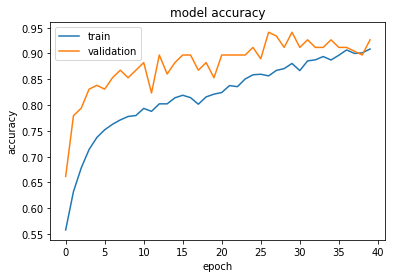

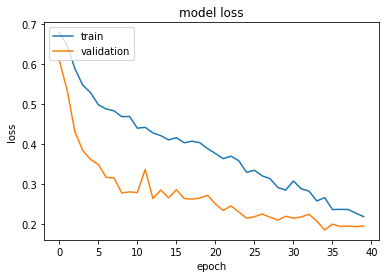

Time passed for training 5.23674141963323
Train label distribution:  label
0    640
1    772
Name: label, dtype: int64
num_of_classes 2
Val label distribution:  label
0    23
1    45
Name: label, dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_40 (Masking)         (None, None, 300)         0         
_________________________________________________________________
gru_103 (GRU)                (None, None, 27)          26568     
_________________________________________________________________
gru_104 (GRU)                (None, 27)                4455      
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 56        
Total params: 31,079
Trainable params: 31,079
Non-trainable params: 0
_________________________________________________________________
None
Train on 1412 samples, validate on 68 samples
Epoch 1/10

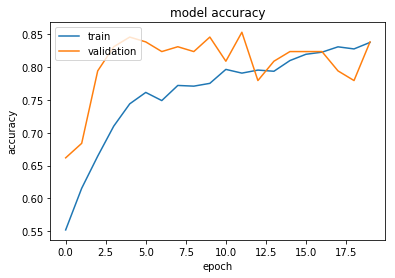

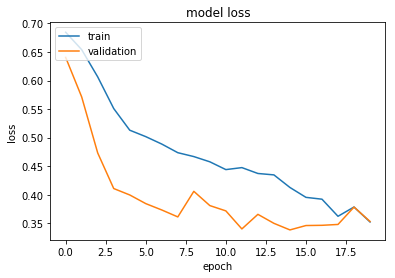

Time passed for training 6.591136900583903
Train label distribution:  label
0    640
1    772
Name: label, dtype: int64
num_of_classes 2
Val label distribution:  label
0    23
1    45
Name: label, dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_41 (Masking)         (None, None, 300)         0         
_________________________________________________________________
gru_105 (GRU)                (None, None, 27)          26568     
_________________________________________________________________
gru_106 (GRU)                (None, 27)                4455      
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 56        
Total params: 31,079
Trainable params: 31,079
Non-trainable params: 0
_________________________________________________________________
None
Train on 1412 samples, validate on 68 samples
Epoch 1/1

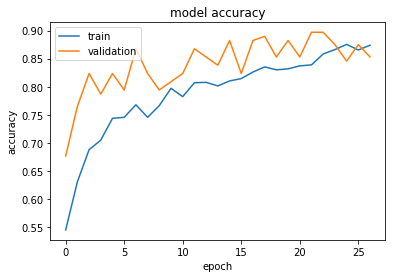

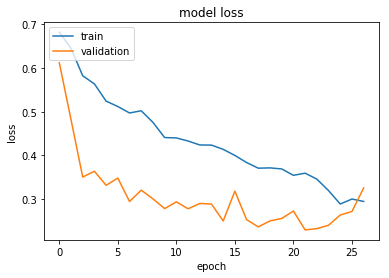

Time passed for training 8.366247137387594
Train label distribution:  label
0    640
1    772
Name: label, dtype: int64
num_of_classes 2
Val label distribution:  label
0    23
1    45
Name: label, dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_42 (Masking)         (None, None, 300)         0         
_________________________________________________________________
gru_107 (GRU)                (None, None, 27)          26568     
_________________________________________________________________
gru_108 (GRU)                (None, 27)                4455      
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 56        
Total params: 31,079
Trainable params: 31,079
Non-trainable params: 0
_________________________________________________________________
None
Train on 1412 samples, validate on 68 samples
Epoch 1/1

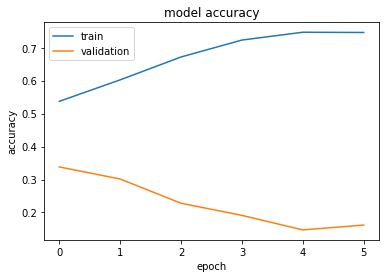

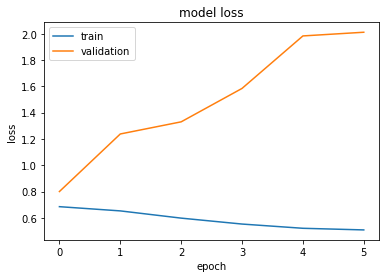

Time passed for training 8.952114983399708
Cross-validation val accuracy results:  [0.8714285697255816, 0.9, 0.3382352941176471, 0.9411764705882353, 0.8529411764705882, 0.8970588235294118, 0.3382352941176471]
Cross-validation val accuracy results: 0.73% (+/- 0.25%)

 Cross-validation val f1 results:  [0.8714285101209368, 0.8999999455043248, 0.34773750515545115, 0.9411764144897461, 0.852941120372099, 0.8970587674309226, 0.33823523801915784]
Cross-validation val f1 results: 0.74% (+/- 0.25%)
Total time passed for training 8.95319423675537


In [31]:
cleaned_twitter_dataset_path = "/home/elkhand/datasets/twitter-sentiment/Cleaned_Sentiment_Analysis_Dataset.csv"

import tensorflow as tf
tf.Session(config=tf.ConfigProto(log_device_placement=True))


def build_model(isBinaryClassification, max_seq_len, num_of_classes, embedding_dim, hidden_layer_dim, dropout, recurrent_dropout, final_activation): 
    # Cross-validation results: 0.61% (+/- 0.13%)
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, embedding_dim)))
    #, dropout=dropout, recurrent_dropout=recurrent_dropout
    model.add(GRU(max_seq_len,return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
    #model.add(GRU(max_seq_len // 2,return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
    #model.add(Dropout(dropout))
    model.add(GRU(max_seq_len, dropout=dropout, recurrent_dropout=recurrent_dropout)) 
    #model.add(Dropout(dropout))
    
    
    model.add(Dense(num_of_classes, activation=final_activation))

    if isBinaryClassification:
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1, recall, precision])#
    else:
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=['accuracy', f1, recall, precision])#
    print(model.summary())
    return model

def twitter_train_StratifiedKFold(isBinaryClassification):
    """StratifiedKFold cross-validation to solve class imbalance issue"""
    
    dfTwitter = pd.read_csv(cleaned_twitter_dataset_path, header=0)
    print(dfTwitter.head())
    dfTwitter.columns = ['caption', 'label']
    dfTwitter = dfTwitter.dropna()
    dfTwitterPos = dfTwitter[dfTwitter.label == 1]
    dfTwitterPos = dfTwitterPos[:500]
    dfTwitterNeg = dfTwitter[dfTwitter.label == 0]
    dfTwitterNeg = dfTwitterNeg[:500]
    dfTwitter =  pd.concat([dfTwitterNeg, dfTwitterPos]) 

    print("dfTwitter.count()",dfTwitter.count())

    dfCaption = pd.read_csv(dataset_path, header=0, sep="|")
    # Doing only binary classification
    if isBinaryClassification:
        dfCaption = get_df_for_binary_classification()
    

    print("Label distribution: ",dfCaption.groupby('label').label.count())
    max_seq_len_captions = int(dfCaption['caption'].map(lambda x: get_non_stop_word_count(x.split())).max())
    print("max_seq_len_captions", max_seq_len_captions)
    
    max_seq_len_tweets = int(dfTwitter['caption'].map(lambda x: len(x.split())).max())
    print("max_seq_len_tweets", max_seq_len_tweets)
    
    max_seq_len = max(max_seq_len_captions,max_seq_len_tweets)
    print("max_seq_len", max_seq_len)
    
    
    
    X = dfCaption['caption']
    y = dfCaption['label']
    
 
    
    if isBinaryClassification:
        final_activation ='sigmoid'
    else:
        final_activation ='softmax'
    print("final_activation",final_activation)
    
    
    # Instantiate the cross validator
    skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
    printCnt = 5
    cv_accuracies = []
    cv_f1s = []
    
    # Loop through the indices the split() method returns
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        
        X_train_caption, X_val_caption = X[train_indices], X[val_indices]
        y_train_caption, y_val_caption = y[train_indices], y[val_indices]
        
        dfCaptionTrain = pd.concat([X_train_caption, y_train_caption], axis=1) 
        
        dfTweetCaptionTrain = pd.concat([dfTwitter, dfCaptionTrain])               
        
        X_train, y_train_index, num_of_classes = load_dataset_StratifiedKFold(dfTweetCaptionTrain, max_seq_len)
        y_train = convert_index_to_one_hot(y_train_index, num_of_classes)
        print("Train label distribution: ",dfTweetCaptionTrain.groupby('label').label.count())
        print("num_of_classes",num_of_classes)
        
        dfCaptionVal = pd.concat([X_val_caption, y_val_caption], axis=1) 
        
        X_val, y_val_index, _ = load_dataset_StratifiedKFold(dfCaptionVal,max_seq_len)
        y_val = convert_index_to_one_hot(y_val_index, num_of_classes) 
        print("Val label distribution: ",dfCaptionVal.groupby('label').label.count())       

        model = build_model(isBinaryClassification,
                               max_seq_len,
                                num_of_classes, 
                                embedding_dim=300, 
                                hidden_layer_dim=40, 
                                dropout=0.2, 
                                recurrent_dropout=0.2,# 0.3
                                final_activation=final_activation
                                )
        plot_model(model, to_file= 'model/model.png', show_shapes=True, show_layer_names=True)#

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.2, 
                                      patience=5, 
                                      min_lr=0.001)

        history = {}
        filename = ""
        # checkpoint
        filepath="model/weights.best.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', patience=5)    
        callbacks_list = [ checkpoint, early_stopping, reduce_lr]  #
        history = model.fit(x=X_train,
                          y=y_train, 
                          batch_size=32,# 64 seems fine, 32 is better 
                          epochs=100, 
                          verbose=1, 
                          validation_data = (X_val, y_val),
                          shuffle=True,
                          callbacks=callbacks_list)        
        val_acc_list = history.history['val_acc']
        val_f1_list = history.history['val_f1']
        best_val_acc =  max(val_acc_list)
        best_f1 =  max(val_f1_list)
        print("best_val_acc: ", best_val_acc)
        print("best_f1: ", best_f1)
        filename = "hec" 
        filename = "model/" + generate_model_name(filename, best_val_acc) + ".h5"
        os.rename(filepath, filename)
        cv_accuracies.append(best_val_acc)
        cv_f1s.append(best_f1)
        plot_model_accuracy(history)
        end = time.time()
        print("Time passed for training", (end-start)/60)
    
    print("=========================================")
    print("Cross-validation val accuracy results: " , cv_accuracies)
    print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))
    
    print("\n","Cross-validation val f1 results: " , cv_f1s)
    print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))
    
    
    return history


dataset_path = human_output_caption_to_label_csv_path
kfold_splits = 7
# dataset_path = auto_output_caption_to_label_csv_path


embedding_dimension = 300
class_to_index = {}
index_to_class = {}
#max_seq_len = 40
start = time.time()
isBinaryClassification = True
history = twitter_train_StratifiedKFold(isBinaryClassification) 
#dataset_path = caption_to_label_dataset_path + "/" +'human-train.csv'
#val_dataset_path = caption_to_label_dataset_path + "/" +'human-val.csv'
#history = train()
end = time.time()
print("Total time passed for training", (end-start)/60)


In [22]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

tf = tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.list_devices()

[]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2014422686290697
]


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]